In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import sys

import mlflow
import numpy as np
import squidpy as sq

from autotalker.analysis import plot_latent_umap
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker

In [3]:
dataset = "squidpy_seqfish"
n_epochs = 5
lr = 0.01
batch_size = 128
n_hidden = 32
n_latent = 16
dropout_rate = 0.

In [4]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"

Using dataset squidpy_seqfish.


In [5]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


In [6]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [7]:
model = Autotalker(adata,
                   cell_type_key=cell_type_key,
                   n_hidden=n_hidden,
                   n_latent=n_latent,
                   dropout_rate=dropout_rate)

model.train(n_epochs=n_epochs,
            lr=lr,
            batch_size=batch_size,
            mlflow_experiment_id=experiment.experiment_id)

model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

 |████████████████████| 100.0%  - train_losses: 0.4694968229 - valid_losses: 0.4720614279 - valid_auroc_scores: 0.9398735178 - valid_auprc_scores: 0.9123177623 - valid_best_acc_scores: 0.8968236502 - valid_best_f1_scores: 0.9031468419
Saving best state of the network...
Best state was in epoch 4
Model training finished...


In [8]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad",
                        use_cuda=True)

In [9]:
labeled_latent_adata = model.get_labeled_latent_adata()

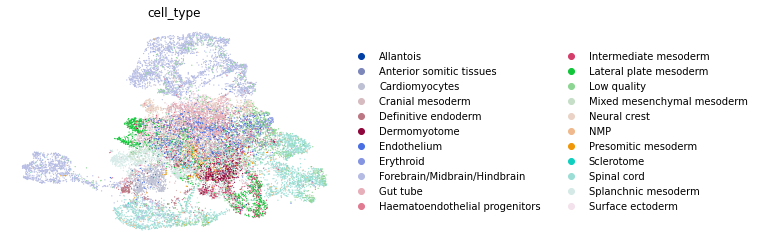

<Figure size 432x288 with 0 Axes>

In [10]:
plot_latent_umap(labeled_latent_adata,
                 save=True,
                 save_dir_path="analysis_artefacts")